In [1]:
import os
import random
import h5py
import math
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import cardiax
import deepx
from deepx import generate

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [86]:
def entropy(a):
    def _entropy(a, axis):
        a_x = cardiax.solve.gradient(a, axis)
        idx_x, _ = jax.numpy.histogram(a_x, bins=64)
        idx_x = normalise(idx_x)
        return -jnp.mean(idx_x * jnp.log(idx_x + 1e-9))
    return jnp.sum(jnp.array([_entropy(a, i) for i in range(len(a.shape))]))

0.15650529


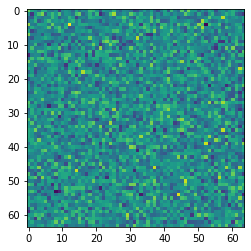

0.0026861755


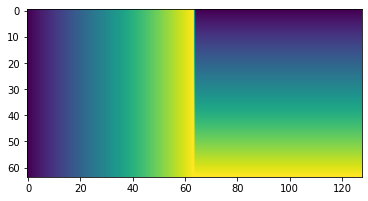

In [88]:
a = jax.random.normal(jax.random.PRNGKey(0), (64, 64))
e_a = entropy(a)
print(e_a)
plt.imshow(a)
plt.show()

b = jnp.hstack(jax.numpy.meshgrid(jnp.arange(0, 64), jnp.arange(0, 64)))
e_b = entropy(b)
print(e_b)
plt.imshow(b)
plt.show()

In [2]:
SEED = 0
PARAMS = cardiax.params.PARAMSET_3  # change the parameter set here  (params, dot, should give you intellisense for the options)
SHAPE = (1200, 1200)  # in adimensional units: (cm) = (units) * dx
START = 0  # in adimensional units: (ms) =  (timesteps) * dx
STOP = 100_000  # in adimensional units: (ms) =  (timesteps) * dx
CHECKPOINT_EVERY = 5000  # in adimensional units: (ms) = (timesteps) * dx
dt = 0.01
dx = 0.01
INTEGRATOR = cardiax.solve.TimeIntegrator.HEUN

# for random sequences to save on disk
N_STIMULI=3 
FILEPATH = "data/test_{}.hdf5"
RESHAPE = (256, 256)  # in adimensional units: (ms) =  (timesteps) / dx
SAVE_INTERVAL_ms = 1 
USE_MEMORY = True
PLOT_WHILE = True

In [3]:
initial_state = cardiax.solve.init(SHAPE)

def check(seed):
    rng = jax.random.PRNGKey(seed)

    # generate random conductivity map
    diffusivity = generate.random_diffusivity(rng, SHAPE)

    # generate random stimuli
    protocol_1 = generate.random_protocol(rng, min_start=0, max_start=0)
    protocol_2 = generate.random_protocol(rng, min_start=40_000, max_start=40_000)
    stimuli = [
            generate.random_rectangular_stimulus(rng, SHAPE, protocol_1, modulus=20.0),
            generate.random_triangular_stimulus(rng, SHAPE, protocol_2, modulus=20.0)
    ]

    # fig, ax = cardiax.plot.plot_stimuli(stimuli)
    # fig.suptitle("Stimuli")
    fig, ax = cardiax.plot.plot_diffusivity(diffusivity)
    fig.suptitle("Diffusivity")
    plt.show()
    return


def visualise(seed, integrator):
    rng = jax.random.PRNGKey(seed)

    # generate random conductivity map
    diffusivity=generate.random_diffusivity(rng, SHAPE)

    # generate random stimuli
    protocol_1 = generate.random_protocol(rng, min_start=0, max_start=0)
    protocol_2 = generate.random_protocol(rng, min_start=40_000, max_start=40_000)
    stimuli = [
            generate.random_rectangular_stimulus(rng, SHAPE, protocol_1, modulus=20.0),
            generate.random_triangular_stimulus(rng, SHAPE, protocol_2, modulus=20.0)
    ]
    
    checkpoint_states = cardiax.solve.forward(
        initial_state,
        jnp.arange(START, STOP, CHECKPOINT_EVERY),
        PARAMS,
        diffusivity, 
        stimuli,
        dt,
        dx,
        plot_while=True,
        integrator=integrator,
    )
    return checkpoint_states

    def make_hdf5(seed):
        rng = jax.random.PRNGKey(seed)
        return deepx.generate.random_sequence(
            rng,
            PARAMS,
            FILEPATH.format(seed),
            SHAPE,
            N_STIMULI,
            reshape=RESHAPE,
            use_memory=USE_MEMORY,
            plot_while=PLOT_WHILE,
        )

Tissue size is: (12, 12) - Computing on grid (1200, 1200)
Checkpointing every 100 steps
Cell parameters Params(tau_v_plus=3.33, tau_v1_minus=19.6, tau_v2_minus=1250, tau_w_plus=870, tau_w_minus=41, tau_d=0.25, tau_0=12.5, tau_r=33.33, tau_si=29, k=10, V_csi=0.85, V_c=0.13, V_v=0.04, Cm=1)


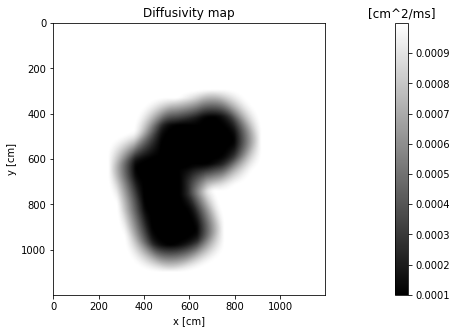

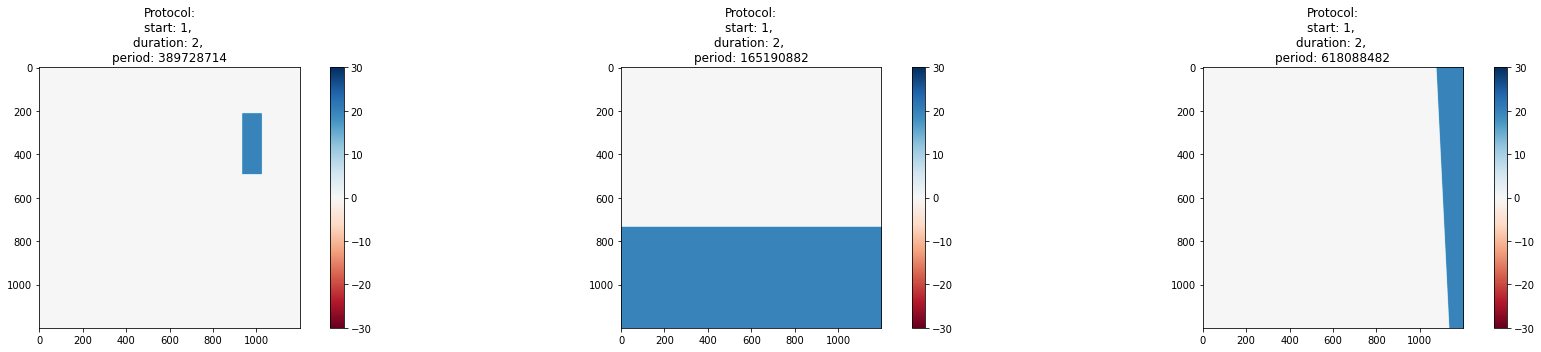

In [ ]:
for i in range(10):
    make_hdf5(i)